<a href="https://colab.research.google.com/github/KennedyWaweru/Udacity/blob/main/courses/udacity_intro_to_tensorflow_for_deep_learning/Saving_and_loading_tf_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

In [ ]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

In [ ]:
# train a model on the cats and dogs dataset
splits = ['train[:80%]','train[80%:]']
(training_set, validation_set), info = tfds.load(
    'cats_vs_dogs',
    split=splits,
    with_info=True,
    as_supervised=True
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteK9V2XG/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
num_classes = info.features['label'].num_classes
num_training_examples = tf.data.experimental.cardinality(training_set).numpy()
num_validation_examples = tf.data.experimental.cardinality(validation_set).numpy()

print("Number of classes: ",num_classes)
print("Number of training examples: ",num_training_examples)
print("Number of validation examples: ", num_validation_examples)

Number of classes:  2
Number of training examples:  18610
Number of validation examples:  4652


In [ ]:
IMAGE_RES = 224
def format_image(image,label):
  image = tf.image.resize(image,(IMAGE_RES,IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32
training_batch = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batch = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
# load a pretrained tensorflow model from tensorflow hub
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(
    URL,
    input_shape=(IMAGE_RES,IMAGE_RES,3)
)

In [ ]:
# freeze the trained model for transer learning
feature_extractor.trainable = False

In [ ]:
# add a classification header
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)                  
]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 3

history = model.fit(
    training_batch,
    validation_data=validation_batch,
    epochs=EPOCHS
)

Epoch 1/3
582/582 [==============================] - 51s 60ms/step - loss: 0.0553 - accuracy: 0.9800 - val_loss: 0.0312 - val_accuracy: 0.9890
Epoch 2/3
582/582 [==============================] - 39s 62ms/step - loss: 0.0305 - accuracy: 0.9894 - val_loss: 0.0323 - val_accuracy: 0.9899
Epoch 3/3
582/582 [==============================] - 39s 62ms/step - loss: 0.0250 - accuracy: 0.9921 - val_loss: 0.0294 - val_accuracy: 0.9918


In [ ]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [ ]:
# create batches for image and associated labels
image_batch, label_batch = next(iter(training_batch.take(1)))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_labels = class_names[predicted_ids]
predicted_labels

array(['cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat',
       'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog',
       'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog',
       'dog', 'dog', 'dog', 'cat', 'cat'], dtype='<U3')

In [ ]:
label_batch

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

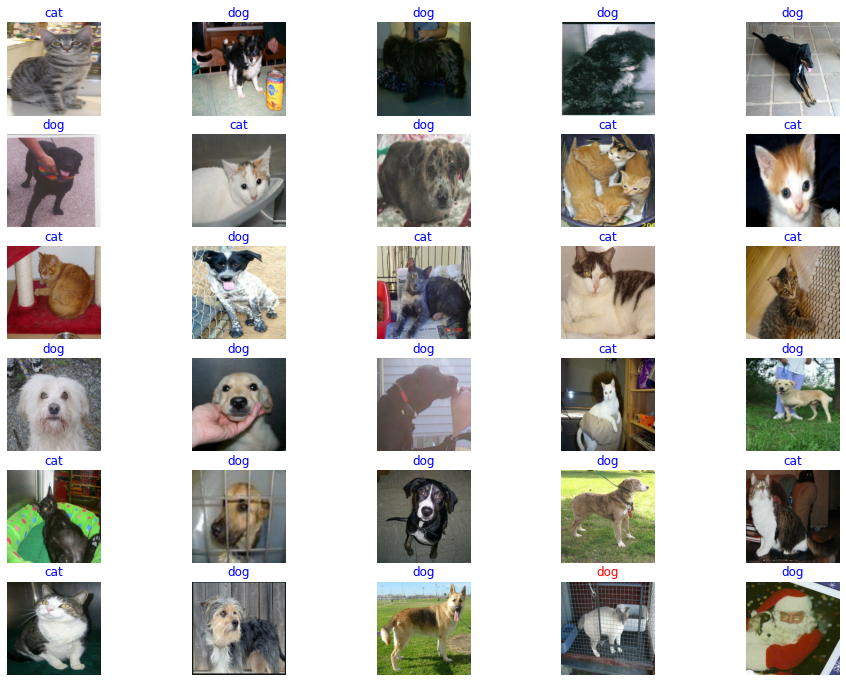

In [ ]:
plt.figure(figsize=(16,12))
for i in range(0,30):
  plt.subplot(6,5,i+1)
  plt.imshow(image_batch[i])
  color = "blue" if predicted_ids[i]==label_batch[i] else "red"
  plt.title(predicted_labels[i],color=color)
  plt.axis('off')

In [ ]:
# save as Keras h5 model

In [ ]:
t = time.time()
export_path = f"/{int(t)}"
export_path

'/1650960235'

In [ ]:
tf.saved_model.save(model,export_path)

INFO:tensorflow:Assets written to: /1650960235/assets


INFO:tensorflow:Assets written to: /1650960235/assets


In [ ]:
!ls {export_path}

assets	saved_model.pb	variables


In [ ]:
model.save(export_path)

INFO:tensorflow:Assets written to: /1650960235/assets


INFO:tensorflow:Assets written to: /1650960235/assets


In [ ]:
!ls {export_path}

assets	keras_metadata.pb  saved_model.pb  variables


In [ ]:
reload_sm_keras = tf.keras.models.load_model(
  export_path,
  custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
reload_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# download your model to a local file
!zip -r model.zip {export_path}

!ls

  adding: 1650960235/ (stored 0%)
  adding: 1650960235/assets/ (stored 0%)
  adding: 1650960235/variables/ (stored 0%)
  adding: 1650960235/variables/variables.index (deflated 78%)
  adding: 1650960235/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1650960235/keras_metadata.pb (deflated 80%)
  adding: 1650960235/saved_model.pb (deflated 92%)
model.zip  sample_data


In [ ]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>